In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.ImageTransformer import ImageTransformer
from utils.Interpolator import Interpolator

In [2]:
img = cv2.imread("./Jazz.jpeg")

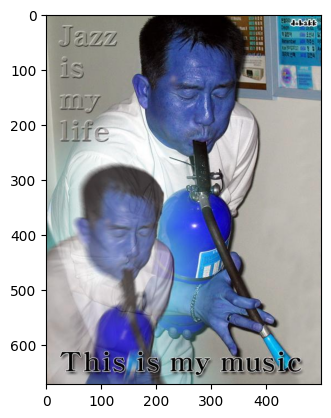

In [3]:
plt.imshow(img)

In [4]:
import math

def gauss(x, gamma=1, shift=0):
    return (1/(gamma*(2*math.pi)**0.5))*np.exp(-((x-shift)**2)/(2*(gamma**2)))

def gaussian_filter(size, gamma=1, shift=0):
    ar = np.arange(size)-size//2
    index = gauss(ar,gamma,shift).reshape([1,size])
    return index*index.T

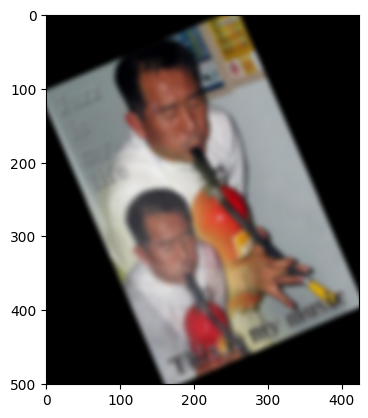

In [6]:
gaussian = gaussian_filter(15, 3.5)

plt.imshow(ImageTransformer(
    img, 
    interpolator=Interpolator.Triangular()
).scale(
    scale_width=0.581, 
    scale_height=0.649238
).rotate(
    rotate_degree=23.2356,
    mode="fit"
).filtering(
    gaussian
).build()[...,::-1])